In [1]:
import gym
from gym import spaces
from gym.utils import seeding
from tqdm import tqdm

In [2]:
import pandas as pd
import numpy as np
import typing
from datetime import datetime

In [3]:
import ray
# Start up Ray. This must be done before we instantiate any RL agents.
ray.init(num_cpus=10, ignore_reinit_error=True, log_to_driver=False,_temp_dir="/rds/general/user/asm119/ephemeral")

2020-12-02 09:49:41,617	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.0.0.1',
 'raylet_ip_address': '192.0.0.1',
 'redis_address': '192.0.0.1:6379',
 'object_store_address': '/rds/general/user/asm119/ephemeral/session_2020-12-02_09-49-39_385980_2802831/sockets/plasma_store',
 'raylet_socket_name': '/rds/general/user/asm119/ephemeral/session_2020-12-02_09-49-39_385980_2802831/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/rds/general/user/asm119/ephemeral/session_2020-12-02_09-49-39_385980_2802831',
 'metrics_export_port': 56457,
 'node_id': 'a2f34629866a860a759c85f028327f0e131fdf76'}

In [4]:
tom_path = "../Thomas/"
def load_data(
    price_source: str, 
    tickers: typing.List[str],
    start: datetime, 
    end: datetime, 
    features: typing.List[str],
):
    """Returned price data to use in gym environment"""
    # Load data
    # Each dataframe will have columns date and a collection of fields
    # TODO: DataLoader from mongoDB
    # Raw price from DB, forward impute on the trading days for missing date
    # calculate the features (log return, volatility)
    if price_source in ["csvdata"]:
        feature_df = []
        for t in tickers:
            df1 = pd.read_csv(tom_path + "csvdata/{}.csv".format(t))
            df1['datetime'] = pd.to_datetime(df1['datetime'])
            df1 = df1[(df1['datetime']>=start) & (df1['datetime']<=end)]
            df1.set_index("datetime",inplace=True)
            selected_features = ['return','tcost'] + features
            feature_df.append(df1[selected_features])
            ref_df_columns = df1[selected_features].columns

    # assume all the price_df are aligned and cleaned in the DataLoader
    merged_df = pd.concat(feature_df, axis=1, join="outer")
    # Imputer missing values with zeros 
    price_tensor = merged_df['return'].fillna(0.0).values
    tcost = merged_df['tcost'].fillna(0.0).values

    return {
        "dates": merged_df.index,
        "fields": ref_df_columns,
        "data": merged_df.fillna(0.0).values,
        "pricedata": price_tensor,
        "tcost": tcost,
    }


In [5]:
load_data('csvdata',['SPY','QQQ',], datetime(2010, 5, 4), datetime(2020, 12, 31), ["volatility_20", "skewness_20", "kurtosis_20"] ) ['data'][:10,:]

array([[-2.36998991e-02,  4.25369008e-05,  1.09934270e-02,
        -9.14812793e-01, -2.61064489e-01, -3.01849936e-02,
         1.03231135e-04,  1.16465557e-02, -1.10048552e+00,
         5.96949184e-01],
       [-5.94984959e-03,  4.27953952e-05,  1.09991806e-02,
        -9.10788716e-01, -2.70376218e-01, -5.12061786e-03,
         1.03745202e-04,  1.16723407e-02, -9.95452223e-01,
         4.23777969e-01],
       [-3.36369023e-02,  4.42928644e-05,  1.30807177e-02,
        -9.16682320e-01, -2.54900342e-01, -3.36202334e-02,
         0.00000000e+00,  1.37192261e-02, -9.68839072e-01,
        -4.24718444e-02],
       [-1.49229482e-02,  4.49216118e-05,  1.31754036e-02,
        -7.10326792e-01, -5.75516042e-01, -2.49435926e-02,
         0.00000000e+00,  1.45399702e-02, -7.26873145e-01,
        -6.77999658e-01],
       [ 4.29173814e-02,  4.30496362e-05,  1.66156842e-02,
         3.64864054e-01,  7.49281745e-01,  5.01088321e-02,
         1.04701078e-04,  1.85963149e-02,  4.85487538e-01,
         1.

In [10]:
from empyrical import max_drawdown, alpha_beta, sharpe_ratio, annual_return
from sklearn.preprocessing import StandardScaler 

class Equitydaily(gym.Env):

    def __init__(self,env_config):
        
        self.tickers = env_config['tickers']
        self.lookback = env_config['lookback']
        self.random_start = env_config['random_start']
        self.trading_days = env_config['trading_days'] # Number of days the algorithm runs before resetting
        # Load price data, to be replaced by DataLoader class
        raw_data = load_data(env_config['pricing_source'],env_config['tickers'],env_config['start'],env_config['end'],env_config['features'])
        # Set the trading dates, features and price data 
        self.dates = raw_data['dates']
        self.fields = raw_data['fields']
        self.pricedata = raw_data['pricedata']
        self.featuredata = raw_data['data']
        self.tcostdata = raw_data['tcost']
        # Set up historical actions and rewards 
        self.n_assets = len(self.tickers) + 1
        self.n_metrics = 2 
        self.n_assets_fields = len(self.fields)
        self.n_features = self.n_assets_fields * len(self.tickers) + self.n_assets + self.n_metrics # reward function
        #self.n_features = self.n_assets_fields * len(self.tickers)
        
        # Set up action and observation space
        # The last asset is cash 
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.tickers)+1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.lookback,self.n_features,1), dtype=np.float32)

        self.reset()

        

    def step(self, action):
        
        # Trade every 10 days 
        # Normalise action space 
        if (self.index - self.start_index) % 10 == 0:
            normalised_action = action / np.sum(np.abs(action))
            self.actions = normalised_action
        
        done = False
        # Rebalance portfolio at close using return of the next date
        next_day_log_return = self.pricedata[self.index,:]
        # transaction cost 
        transaction_cost = self.transaction_cost(self.actions,self.position_series[-1])
        
        # Rebalancing 
        self.position_series = np.append(self.position_series, [self.actions], axis=0)
        # Portfolio return 
        today_portfolio_return = np.sum(self.actions[:-1] * next_day_log_return) + np.sum(transaction_cost)
        self.log_return_series = np.append(self.log_return_series, [today_portfolio_return], axis=0)
        
        
        # Calculate reward 
        # Need to cast log_return in pd series to use the functions in empyrical 
        recent_series = pd.Series(self.log_return_series)[-100:]
        #print(recent_series)
        rolling_volatility = np.std(recent_series)
        self.metric = today_portfolio_return / rolling_volatility 
        reward = self.metric
        self.metric_series = np.append(self.metric_series, [self.metric], axis=0)
        
        # Check if the end of backtest
        if self.trading_days is None:
            done = self.index >= self.pricedata.shape[0]-2
        else:
            done = (self.index - self.start_index) >= self.trading_days
            
        # Prepare observation for next day
        self.index += 1
        self.observation = self.get_observation()
            
        return self.observation, reward, done, {}
    
    
    def reset(self):
        self.log_return_series = np.zeros(shape=self.lookback)
        self.metric_series = np.zeros(shape=self.lookback)
        self.position_series = np.zeros(shape=(self.lookback,self.n_assets))
        self.metric = 0           
        if self.random_start:
            num_days = len(self.dates)      
            self.start_index = np.random.randint(self.lookback, num_days - self.trading_days)
            self.index = self.start_index
        else:
            self.start_index = self.lookback
            self.index = self.lookback
        self.actions = np.zeros(shape=self.n_assets)
        self.observation = self.get_observation()
        return self.observation
    
    def get_observation(self):
        # Can use simple moving average data here 
        last_lookback_day = self.index - self.start_index
        price_lookback = self.featuredata[last_lookback_day:last_lookback_day + self.lookback,:]
        metrics = np.vstack((self.log_return_series[last_lookback_day:last_lookback_day + self.lookback], 
                             self.metric_series[last_lookback_day:last_lookback_day + self.lookback])).transpose()
        positions = self.position_series[last_lookback_day:last_lookback_day + self.lookback]
        scaler = StandardScaler()
        price_lookback = scaler.fit_transform(price_lookback)
        observation = np.concatenate((price_lookback, metrics, positions), axis=1)
        return observation.reshape((observation.shape[0], observation.shape[1], 1))
    
    # 0.05% and spread to model t-cost for institutional portfolios 
    def transaction_cost(self, new_action, old_action):
        turnover = np.abs(new_action - old_action) 
        fees = 0.9995 - self.tcostdata[self.index,:]
        fees = np.array(list(fees) + [0.9995])
        tcost = turnover * np.log(fees)
        return tcost 

In [11]:
config = {'pricing_source':'csvdata', 'tickers':['BRK','TLT','QQQ','GLD',], 
          'lookback':100, 'start':'2008-01-02', 'end':'2018-12-31', 'features':["volatility_20", "skewness_20", "kurtosis_20"], 'random_start': True, 'trading_days':600}
EQ_env = Equitydaily(config)

# Training the agent

In [12]:
from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

Instructions for updating:
non-resource variables are not supported in the long term


In [13]:
"""
Set the training env to use random starts as made by Pavol, 506 trading days (2 years of trading) and only before the year 2014. Everything after that will be used as a dev set.
We use a 60 day look back as used here https://www.oxford-man.ox.ac.uk/wp-content/uploads/2020/06/Deep-Reinforcement-Learning-for-Trading.pdf.
This isn't gospel. It's a starting point

"""
train_agent_config = {'pricing_source':'csvdata', 'tickers':['BRK','TLT','QQQ','GLD',], 
          'lookback':60, 'start':'2008-01-02', 'end':'2013-12-31', 'features':["volatility_20", "skewness_20", "kurtosis_20"], 'random_start': True, 'trading_days':506}
train_env = Equitydaily(train_agent_config)

In [28]:
config = DEFAULT_CONFIG.copy()
config['num_workers'] = 1
config["num_envs_per_worker"] = 1
config["rollout_fragment_length"] = 20
config["train_batch_size"] = 5000
config["batch_mode"] = "complete_episodes"
config['num_sgd_iter'] = 20
config['sgd_minibatch_size'] = 200
config['model']['dim'] = 200
config['model']['conv_filters'] = [[32, [5, 1], 5], [32, [5, 1], 5], [4, [5, 1], 5]]
config['num_cpus_per_worker'] = 2  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['env_config'] = train_agent_config

In [33]:
#train the model using only the training data

config = DEFAULT_CONFIG.copy()
config['num_workers'] = 5
config["num_envs_per_worker"] = 1
config["rollout_fragment_length"] = 20
config["train_batch_size"] = 1200
config["batch_mode"] = "complete_episodes"
config['num_sgd_iter'] = 20
config['sgd_minibatch_size'] = 200
config['model']['dim'] = 200
config['model']['conv_filters'] = [[32, [5, 1], 5], [32, [5, 1], 5], [4, [5, 1], 5]]
config['num_cpus_per_worker'] = 2  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['env_config'] = train_agent_config

In [34]:
agent = PPOTrainer(config, Equitydaily)
best_reward = -np.inf

RayTaskError(ValueError): [36mray::RolloutWorker.foreach_policy()[39m (pid=2805496, ip=192.0.0.1)
  File "/rds/general/user/asm119/home/anaconda3/envs/reinforcement/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 1812, in _create_c_op
    c_op = pywrap_tf_session.TF_FinishOperation(op_desc)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Negative dimension size caused by subtracting 5 from 3 for '{{node default_policy/conv3/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 5, 5, 1], use_cudnn_on_gpu=true](default_policy/conv2/Relu, default_policy/conv3/Conv2D/ReadVariableOp)' with input shapes: [?,3,2,32], [5,1,32,4].

During handling of the above exception, another exception occurred:

[36mray::RolloutWorker.foreach_policy()[39m (pid=2805496, ip=192.0.0.1)
  File "python/ray/_raylet.pyx", line 443, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 477, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 481, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 482, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 436, in ray._raylet.execute_task.function_executor
  File "/rds/general/user/asm119/home/anaconda3/envs/reinforcement/lib/python3.7/site-packages/ray/rllib/evaluation/rollout_worker.py", line 454, in __init__
    self._build_policy_map(policy_dict, policy_config)
  File "/rds/general/user/asm119/home/anaconda3/envs/reinforcement/lib/python3.7/site-packages/ray/rllib/evaluation/rollout_worker.py", line 1059, in _build_policy_map
    policy_map[name] = cls(obs_space, act_space, merged_conf)
  File "/rds/general/user/asm119/home/anaconda3/envs/reinforcement/lib/python3.7/site-packages/ray/rllib/policy/tf_policy_template.py", line 221, in __init__
    obs_include_prev_action_reward=obs_include_prev_action_reward)
  File "/rds/general/user/asm119/home/anaconda3/envs/reinforcement/lib/python3.7/site-packages/ray/rllib/policy/dynamic_tf_policy.py", line 203, in __init__
    framework="tf")
  File "/rds/general/user/asm119/home/anaconda3/envs/reinforcement/lib/python3.7/site-packages/ray/rllib/models/catalog.py", line 398, in get_model_v2
    name, **model_kwargs)
  File "/rds/general/user/asm119/home/anaconda3/envs/reinforcement/lib/python3.7/site-packages/ray/rllib/models/tf/visionnet.py", line 69, in __init__
    name="conv{}".format(len(filters)))(last_layer)
  File "/rds/general/user/asm119/home/anaconda3/envs/reinforcement/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer_v1.py", line 776, in __call__
    outputs = call_fn(cast_inputs, *args, **kwargs)
  File "/rds/general/user/asm119/home/anaconda3/envs/reinforcement/lib/python3.7/site-packages/tensorflow/python/keras/layers/convolutional.py", line 247, in call
    outputs = self._convolution_op(inputs, self.kernel)
  File "/rds/general/user/asm119/home/anaconda3/envs/reinforcement/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py", line 201, in wrapper
    return target(*args, **kwargs)
  File "/rds/general/user/asm119/home/anaconda3/envs/reinforcement/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py", line 1017, in convolution_v2
    name=name)
  File "/rds/general/user/asm119/home/anaconda3/envs/reinforcement/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py", line 1147, in convolution_internal
    name=name)
  File "/rds/general/user/asm119/home/anaconda3/envs/reinforcement/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py", line 2591, in _conv2d_expanded_batch
    name=name)
  File "/rds/general/user/asm119/home/anaconda3/envs/reinforcement/lib/python3.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 979, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/rds/general/user/asm119/home/anaconda3/envs/reinforcement/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 744, in _apply_op_helper
    attrs=attr_protos, op_def=op_def)
  File "/rds/general/user/asm119/home/anaconda3/envs/reinforcement/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3485, in _create_op_internal
    op_def=op_def)
  File "/rds/general/user/asm119/home/anaconda3/envs/reinforcement/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 1975, in __init__
    control_input_ops, op_def)
  File "/rds/general/user/asm119/home/anaconda3/envs/reinforcement/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 1815, in _create_c_op
    raise ValueError(str(e))
ValueError: Negative dimension size caused by subtracting 5 from 3 for '{{node default_policy/conv3/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 5, 5, 1], use_cudnn_on_gpu=true](default_policy/conv2/Relu, default_policy/conv3/Conv2D/ReadVariableOp)' with input shapes: [?,3,2,32], [5,1,32,4].

2020-12-02 10:23:20,549	ERROR worker.py:1037 -- Possible unhandled error from worker: ray::RolloutWorker.__init__() (pid=2805682, ip=192.0.0.1)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Negative dimension size caused by subtracting 5 from 3 for '{{node default_policy/conv3/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 5, 5, 1], use_cudnn_on_gpu=true](default_policy/conv2/Relu, default_policy/conv3/Conv2D/ReadVariableOp)' with input shapes: [?,3,2,32], [5,1,32,4].

During handling of the above exception, another exception occurred:

ray::RolloutWorker.__init__() (pid=2805682, ip=192.0.0.1)
  File "python/ray/_raylet.pyx", line 477, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 481, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 482, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 436, in ray._raylet.execute_task.function_executor
  F

In [13]:
for i in tqdm(range(10)):
    result = agent.train()
    if result['episode_reward_mean'] > best_reward + 10:
        path = agent.save('./sampleagent2/')
        print(path)
        best_reward = result['episode_reward_mean']
        print(best_reward)

  0%|          | 0/10 [00:00<?, ?it/s]


NameError: name 'agent' is not defined

In [28]:
EQ_env.observation.shape, EQ_env.n_features

((100, 27, 1), 27)

In [29]:
EQ_env.reset()
_, rw, _, _ = EQ_env.step([ 0.4612986,  -0.3883527,  -0.45688114, -0.06747285, -0.1717046])
print(rw)

-10.05037815259212


In [30]:
EQ_env.observation

array([[[-1.96203294],
        [ 0.38927695],
        [ 1.30878227],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[-0.92275479],
        [ 0.9387753 ],
        [ 1.11769825],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[ 0.04201546],
        [ 0.53240954],
        [ 1.08120239],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       ...,

       [[-1.20326979],
        [-0.30100075],
        [ 0.91832445],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[ 0.95157447],
        [-0.19321166],
        [ 0.62708665],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[-0.50030785],
        [-0.3025445 ],
        [ 0.6640653 ],
        ...,
        [-0.29558014],
        [-0.04365169],
        [-0.11108462]]])

<AxesSubplot:>

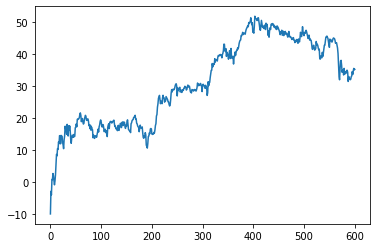

In [33]:
state = EQ_env.reset()
done = False
reward_list = []
cum_reward = 0
actions = list()

while not done:
    #action = agent.compute_action(state)
    action = np.array([1,0,0,0,0])
    state, reward, done, future_price = EQ_env.step(action)
    cum_reward += reward
    actions.append(action)
    reward_list.append(reward)

pd.Series(reward_list).cumsum().plot()

<AxesSubplot:>

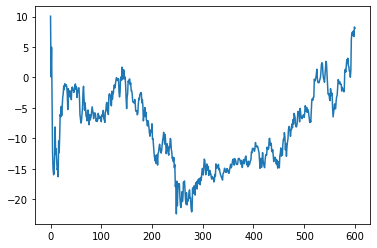

In [34]:
state = EQ_env.reset()
done = False
reward_list = []
cum_reward = 0
actions = list()

while not done:
    #action = agent.compute_action(state)
    action = np.array([1,0,0,0,0])
    state, reward, done, future_price = EQ_env.step(action)
    cum_reward += reward
    actions.append(action)
    reward_list.append(reward)

pd.Series(reward_list).cumsum().plot()

PPO policy

In [35]:
from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

Instructions for updating:
non-resource variables are not supported in the long term


In [36]:
config = DEFAULT_CONFIG.copy()
config['num_workers'] = 5
config["num_envs_per_worker"] = 1
config["rollout_fragment_length"] = 20
config["train_batch_size"] = 1200
config["batch_mode"] = "complete_episodes"
config['num_sgd_iter'] = 20
config['sgd_minibatch_size'] = 200
config['model']['dim'] = 200
config['model']['conv_filters'] = [[32, [5, 1], 5], [32, [5, 1], 5], [4, [5, 1], 5]]
config['num_cpus_per_worker'] = 2  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['env_config'] = {'pricing_source':'csvdata', "tickers": ["BRK_A", "GE_","GOLD_", "AAPL_","GS_","T_",],
          'lookback':200, 'start':'1995-01-02', 'end':'2018-12-31', 'features':["return_volatility_20", "return_skewness_20", "return_kurtosis_20"],
          'random_start': True, 'trading_days': 600}

In [37]:
config

{'num_workers': 5,
 'num_envs_per_worker': 1,
 'create_env_on_driver': False,
 'rollout_fragment_length': 20,
 'batch_mode': 'complete_episodes',
 'num_gpus': 0,
 'train_batch_size': 1200,
 'model': {'fcnet_hiddens': [256, 256],
  'fcnet_activation': 'tanh',
  'conv_filters': [[32, [5, 1], 5], [32, [5, 1], 5], [4, [5, 1], 5]],
  'conv_activation': 'relu',
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': True,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action_reward': False,
  '_time_major': False,
  'framestack': True,
  'dim': 200,
  'grayscale': False,
  'zero_mean': True,
  'custom_model': None,
  'custom_model_config': {},
  'custom_action_dist': None,
  'custom_preprocessor': None},
 'optimizer': {},
 'gamma': 0.99,
 'horizon': None,
 'soft_horizon': False,
 'no_done_at_end': False,
 'env_config': {'pricing_source': 'csvdata',
  'tickers': ['BRK_A', 'GE_', 'GOLD_', 'AAPL_', 'GS_', 'T_'],
  'lookback': 200,
  'start'

Check to see if agents can be trained

In [38]:
agent = PPOTrainer(config, Equitydaily)
best_reward = -np.inf

2020-12-01 21:29:20,343	INFO trainer.py:592 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2020-12-01 21:29:20,344	INFO trainer.py:1065 -- `_use_trajectory_view_api` only supported for PyTorch so far! Will run w/o.
2020-12-01 21:29:20,345	INFO trainer.py:619 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-12-01 21:29:37,701	INFO trainable.py:255 -- Trainable.setup took 17.361 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2020-12-01 21:29:37,704	WARNING util.py:40 -- Install gputil for GPU system monitoring.


In [ ]:
for i in tqdm(range(300)):
    result = agent.train()
    if result['episode_reward_mean'] > best_reward + 10:
        path = agent.save('sampleagent')
        print(path)
        best_reward = result['episode_reward_mean']
        print(best_reward)

  0%|          | 0/300 [00:00<?, ?it/s]

Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


  0%|          | 1/300 [00:09<48:49,  9.80s/it]

sampleagent/checkpoint_1/checkpoint-1
-14.078456598052933


  1%|          | 2/300 [00:18<47:15,  9.52s/it]

sampleagent/checkpoint_2/checkpoint-2
-3.732739231450013


 63%|██████▎   | 190/300 [28:55<16:28,  8.98s/it]

In [ ]:
result

In [84]:
agent.restore('sampleagent/checkpoint_1/checkpoint-1')

2020-11-24 18:16:19,141	INFO trainable.py:482 -- Restored on 192.168.0.101 from checkpoint: sampleagent/checkpoint_1/checkpoint-1
2020-11-24 18:16:19,142	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 24.549320936203003, '_episodes_total': 9}


In [85]:
for i in range(5):
    result = agent.train()
    if result['episode_reward_mean'] > best_reward + 1:
        path = agent.save('sampleagent')
        print(path)
        best_reward = result['episode_reward_mean']
        print(best_reward)

sampleagent/checkpoint_2/checkpoint-2
-18.499785088445154
sampleagent/checkpoint_3/checkpoint-3
-16.556459086976048
sampleagent/checkpoint_4/checkpoint-4
-14.630928403378638


In [86]:
result

{'episode_reward_max': 52.77934555607334,
 'episode_reward_min': -86.04378430659364,
 'episode_reward_mean': -18.523488700115685,
 'episode_len_mean': 601.0,
 'episodes_this_iter': 9,
 'policy_reward_min': {},
 'policy_reward_max': {},
 'policy_reward_mean': {},
 'custom_metrics': {},
 'hist_stats': {'episode_reward': [-45.6825668696604,
   -10.03960208396772,
   -86.04378430659364,
   -17.20824320402023,
   9.652539580057784,
   -31.748727861143124,
   -46.54041751196004,
   -73.66879208983079,
   -47.84958915896191,
   -63.55823822770892,
   -14.381210230459878,
   -2.019125434167244,
   -21.15038879249259,
   -50.66122997210185,
   -51.34743964490648,
   9.509088603245639,
   -39.49717156868493,
   -39.158988309216575,
   -6.857061755878346,
   52.77934555607334,
   -42.36841265278894,
   -33.95732898670692,
   35.229035199981965,
   -84.7391826807767,
   1.2101442723187028,
   -13.324725917295487,
   -33.97551246279332,
   -13.822189658401095,
   16.611751221895165,
   -52.65329252

SAC 

In [ ]:
from ray.rllib.agents.sac import SACTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

In [ ]:
config = DEFAULT_CONFIG.copy()
config['num_workers'] = 1
config["num_envs_per_worker"] = 1

config["rollout_fragment_length"] = 10
config["train_batch_size"] = 50
config["timesteps_per_iteration"] = 10
config["buffer_size"] = 10000

config["Q_model"]["fcnet_hiddens"] = [10, 10]
config["policy_model"]["fcnet_hiddens"] = [10, 10]
config["num_cpus_per_worker"] = 2 
config["env_config"] = {
    "pricing_source": "csvdata",
    "tickers": ["QQQ", "EEM", "TLT", "SHY", "GLD", "SLV"],
    "lookback": 1,
    "start": "2007-01-02",
    "end": "2015-12-31",
}

In [ ]:
# Train agent 
agent = SACTrainer(config, Equitydaily)
best_reward = -np.inf

In [ ]:
for i in range(20):
    result = agent.train()
    if result['episode_reward_mean'] > best_reward + 0.01:
        path = agent.save('sampleagent')
        print(path)
        best_reward = result['episode_reward_mean']
    print(result['episode_reward_mean'])

In [ ]:
result

Run environment 

In [ ]:
config

In [87]:
agent = PPOTrainer(config, Equitydaily)

6042
2010
2020-11-24 18:19:14,974	WARNING util.py:39 -- Install gputil for GPU system monitoring.


In [92]:
env = Equitydaily(config['env_config'])

6042
1190


In [93]:
agent.restore('checkpoint_1087/checkpoint-1087')

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoint_1087/checkpoint-1087.tune_metadata'

In [ ]:
state = env.reset()
done = False
reward_list = []
cum_reward = 0
actions = list()

while not done:
    #action = agent.compute_action(state)
    action = np.array([0,0,0,0,0,0,1])
    state, reward, done, _ = env.step(action)
    cum_reward += reward
    actions.append(action)
    reward_list.append(reward)

pd.Series(env.log_return_series).cumsum().plot()

In [ ]:
pd.Series(reward_list).plot()

In [ ]:
pd.DataFrame(actions)

Run environment for RNN environment

In [ ]:
env = Equitydaily({'pricing_source':'Alpaca_Equity_daily', 'tickers':['SPY','QQQ'], 'lookback':50, 'start':'2018-01-02', 'end':'2020-12-31'})

state = env.reset()
done = False
cum_reward = 0 
actions = list()

rnn_state = agent.get_policy().get_initial_state()

while not done:
    action, rnn_state, _ = agent.compute_action(state,rnn_state)
    #action = np.array([1,-1])
    state, reward, done, _ = env.step(action)
    cum_reward += reward
    actions.append(actions)

pd.Series(env.log_return_series).cumsum().plot()

In [ ]:
max_drawdown(pd.Series(env.log_return_series))

In [ ]:
annual_return(pd.Series(env.log_return_series))

In [ ]:
class Equitydaily_v1(gym.Env):

    def __init__(self,env_config):
        
        self.tickers = env_config['tickers']
        self.lookback = env_config['lookback']
        # Load price data, to be replaced by DataLoader class
        raw_data = load_data(env_config['pricing_source'],env_config['tickers'],env_config['start'],env_config['end'])
        # Set the trading dates, features and price data 
        self.dates = raw_data['dates']
        self.fields = raw_data['fields']
        self.pricedata = raw_data['pricedata']
        self.featuredata = raw_data['data']
        self.tcostdata = raw_data['tcost']
        # Set up historical actions and rewards 
        self.n_assets = len(self.tickers) + 1
        self.n_metrics = 2 
        self.n_assets_fields = len(self.fields)
        self.n_features = self.n_assets_fields * len(self.tickers) + self.n_assets + self.n_metrics # reward function
        
        # Set up action and observation space
        # The last asset is cash 
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.tickers)+1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.lookback,self.n_features), dtype=np.float32)

        self.reset()

        

    def step(self, action):
        
        ## Normalise action space 
        normalised_action = action / np.sum(np.abs(action))
        
        done = False
        # Rebalance portfolio at close using return of the next date
        next_day_log_return = self.pricedata[self.index,:]
        # transaction cost 
        transaction_cost = self.transaction_cost(normalised_action,self.position_series[-1])
        
        # Rebalancing 
        self.position_series = np.append(self.position_series, [normalised_action], axis=0)
        # Portfolio return 
        today_portfolio_return = np.sum(normalised_action[:-1] * next_day_log_return) + np.sum(transaction_cost)
        self.log_return_series = np.append(self.log_return_series, [today_portfolio_return], axis=0)
        
        
        # Calculate reward 
        # Need to cast log_return in pd series to use the functions in empyrical 
        live_days = self.index - self.lookback
        burnin = 250
        recent_series = pd.Series(self.log_return_series)[-100:]
        whole_series = pd.Series(self.log_return_series)
        if live_days > burnin: 
            self.metric = annual_return(whole_series) + 0.5* max_drawdown(whole_series)
        else:
            self.metric = annual_return(whole_series) + 0.5* max_drawdown(whole_series) *live_days / burnin
        reward = self.metric - self.metric_series[-1]
        #reward = self.metric
        self.metric_series = np.append(self.metric_series, [self.metric], axis=0)
        
        # Check if the end of backtest
        if self.index >= self.pricedata.shape[0]-2:
            done = True
            
        # Prepare observation for next day
        self.index += 1
        self.observation = self.get_observation()
            
        return self.observation, reward, done, {'current_price':next_day_log_return}
    
    
    def reset(self):
        self.log_return_series = np.zeros(shape=self.lookback)
        self.metric_series = np.zeros(shape=self.lookback)
        self.position_series = np.zeros(shape=(self.lookback,self.n_assets))
        self.metric = 0                    
        self.index = self.lookback
        self.observation = self.get_observation()
        return self.observation
    
    def get_observation(self):
        # Can use simple moving average data here 
        price_lookback = self.featuredata[self.index-self.lookback:self.index,:]
        metrics = np.vstack((self.log_return_series[self.index-self.lookback:self.index], 
                             self.metric_series[self.index-self.lookback:self.index])).transpose()
        positions = self.position_series[self.index-self.lookback:self.index]
        observation = np.concatenate((price_lookback, metrics, positions), axis=1)
        return observation 
    
    # 0.05% and spread to model t-cost for institutional portfolios 
    def transaction_cost(self,new_action,old_action,):
        turnover = np.abs(new_action - old_action) 
        fees = 0.9995 - self.tcostdata[self.index,:]
        tcost = turnover * np.log(fees)
        return tcost 